In [158]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from IPython.core.debugger import set_trace
%matplotlib notebook

In [137]:
def find_nearest_idx(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [169]:
class Game():
    def __init__(self, game_id):
        self.game_id = game_id
        self.players = None # Dictionary with keys of player ids
        self.events = None # List of events

In [145]:
class Player():
    def __init__(self, player_id):
        self.player_id = player_id
        self.tick_indices = None
        self.kill_indices = None
        self.kill_stamps = None


In [167]:
class Event():
    # Kill event
    def __init__(self, event_id, killer_tick_index, victim_tick_index, killer_id, victim_id):
        self.event_id = event_id
        self.killer_id = killer_id
        self.victim_id = victim_id
        self.killer_tick_index = killer_tick_index # Index for tick for killer
        self.victim_tick_index = victim_tick_index
        
    def getKillerTimestamp(self):
        return id_data.iloc[self.killer_tick_index]['timestamp']
    
    def getVictimTimestamp(self):
        return id_data.iloc[self.victim_tick_index]['timestamp']
    
    def player_kill_pos():
        pos_x = id_data['pos_x'][self.killer_tick_index]
        pos_y = id_data['pos_y'][self.killer_tick_index]
        return float(pos_x), float(pos_y)
    
    def player_death_pos():
        pos_x = id_data['pos_x'][self.victim_tick_index]
        pos_y = id_data['pos_y'][self.victim_tick_index]
        return float(pos_x), float(pos_y)
        

In [166]:
int(id_data.iloc[1]['timestamp'])

1510687275053

In [138]:
id_data = pd.read_csv(
    './pack/data/matches/37549105/ticks.csv')
id_data.head(10)

,Unnamed: 0,recording_id,type_id,timestamp,player_id,pos_x,pos_y,pos_z,rot_x,rot_y,rot_z,flags,speed,vehicle,recording_id.1,session_id,timestamp.1
0,0,3449608,7,1510687274690,3020,-31907.500000,-77257.570312,-2013.723022,1.000000,0.000000,0.000000,0.0,NaN,NaN,3449608,37549105,1510687274690
1,1,3449608,7,1510687275053,3020,-31907.500000,-77257.570312,-2013.723022,0.999998,0.000000,0.002109,0.0,0.000000,NaN,3449608,37549105,1510687274690
2,2,3449608,7,1510687275378,3020,-31907.500000,-77257.570312,-2013.723022,0.495481,-0.860166,-0.120888,0.0,0.000000,NaN,3449608,37549105,1510687274690
3,3,3449608,7,1510687275772,3020,-31907.500000,-77257.570312,-2013.723022,-0.591913,-0.799223,-0.104313,0.0,0.000000,NaN,3449608,37549105,1510687274690
4,4,3449608,7,1510687276141,3020,-31907.500000,-77257.570312,-2013.723022,-0.776267,-0.606164,-0.173134,0.0,0.000000,NaN,3449608,37549105,1510687274690
5,5,3449608,7,1510687276472,3020,-31927.400391,-77262.085938,-2013.723022,-0.958070,-0.177428,-0.224991,0.0,0.061650,NaN,3449608,37549105,1510687274690
6,6,3449608,7,1510687276805,3020,-31945.093750,-77255.718750,-2013.723022,-0.958070,-0.177428,-0.224991,0.0,0.056469,NaN,3449608,37549105,1510687274690
7,7,3449608,7,1510687277181,3020,-31953.791016,-77240.585938,-2013.723022,-0.958070,-0.177428,-0.224991,0.0,0.046420,NaN,3449608,37549105,1510687274690
8,8,3449608,7,1510687277617,3020,-31955.343750,-77239.000000,-2013.723022,-0.959373,-0.180716,-0.216669,0.0,0.005091,NaN,3449608,37549105,1510687274690
9,9,3449608,7,1510687278014,3020,-31945.777344,-77251.078125,-2013.723022,-0.003175,-0.946224,-0.323497,0.0,0.038810,NaN,3449608,37549105,1510687274690


In [139]:
id_kills = pd.read_csv(
    './pack/data/matches/37549105/kills.csv')
id_kills.head(10)

,Unnamed: 0,killer_recording_id,victim_recording_id,timestamp,recording_id,session_id,timestamp.1
0,0,3449687,3443142,1510688133632,3449687,37549105,1510687281295
1,1,3463042,3443144,1510689278868,3463042,37549105,1510688922757
2,2,3448659,3443145,1510687337946,3448659,37549105,1510687147078
3,3,3443257,3443146,1510687547831,3443257,37549105,1510686502645
4,4,3443195,3443177,1510686720106,3443195,37549105,1510686496939
5,5,3443198,3443179,1510686752808,3443198,37549105,1510686497180
6,6,3444818,3443180,1510686832847,3444818,37549105,1510686691851
7,7,3444831,3443181,1510686796092,3444831,37549105,1510686692522
8,8,3451955,3443182,1510687872292,3451955,37549105,1510687583182
9,9,3443186,3443183,1510686925720,3443186,37549105,1510686496939


In [140]:
def player_kill_ticks(tick_indices, kill_indices):

    kill_stamps = id_kills['timestamp'][kill_indices]
    timestamps = id_data['timestamp'][tick_indices]
    kill_ticks_stamps = []
    for i, kill_stamp in enumerate(kill_stamps):    
        kill_tick_idx = find_nearest_idx(timestamps, kill_stamp)
        kill_ticks_stamps.append(timestamps[kill_tick_idx])
    return kill_ticks_stamps

In [141]:
def player_kill_pos(player_id, timestamp):
    kill_indices = id_data['timestamp'] == timestamp
    player_indices = id_data['recording_id'] == player_id
    indices = kill_indices & player_indices
    pos_x = id_data['pos_x'][indices]
    pos_y = id_data['pos_y'][indices]
    return float(pos_x), float(pos_y)

In [173]:
# Construct game
game = Game(37549105)

# Construct players

killer_ids = np.unique(id_kills['killer_recording_id'])

killers = {}
for killer in killer_ids:
    kills = id_kills['killer_recording_id'] == killer
    killers[killer] = id_kills[kills]

player_ids = np.unique(id_data['recording_id'])

players = {}

for player_id in player_ids:
    player = Player(player_id)
    
    # Save player's ticks
    tick_indices = id_data['recording_id'] == player_id
    player.tick_indices = tick_indices
    
    # gathering all the player's kills
    kill_indices = id_kills['killer_recording_id'] == player_id
    player.kill_indices = kill_indices

    # Save kill timestamps
    kill_stamps = player_kill_ticks(player.tick_indices, player.kill_indices)
    player.kill_stamps = kill_stamps
    
    players[player_id] = player
    
game.players = players

# Construct events
for idx in range(0, len(id_kills)):
    row = id_kills.iloc[idx]
    event_id = idx
    killer_id = row['killer_recording_id']
    victim_id = row['victim_recording_id']
    kill_stamp = row['timestamp']

    killer_timestamps = id_data['recording_id'] == killer_id
    killer_timestamps = id_data['timestamp'][timestamps]
    
    kill_tick_idx = find_nearest_idx(killer_timestamps, kill_stamp)
    killer_tick_ = killer_timestamps[kill_tick_idx]

    
    event = Event(event_id, killer_tick_index, victim_tick_index, killer_id, victim_id)

/Library/Python/2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  


Unnamed: 0                         0
killer_recording_id          3449687
victim_recording_id          3443142
timestamp              1510688133632
recording_id                 3449687
session_id                  37549105
timestamp.1            1510687281295
Name: 0, dtype: int64
Unnamed: 0                         1
killer_recording_id          3463042
victim_recording_id          3443144
timestamp              1510689278868
recording_id                 3463042
session_id                  37549105
timestamp.1            1510688922757
Name: 1, dtype: int64
Unnamed: 0                         2
killer_recording_id          3448659
victim_recording_id          3443145
timestamp              1510687337946
recording_id                 3448659
session_id                  37549105
timestamp.1            1510687147078
Name: 2, dtype: int64
Unnamed: 0                         3
killer_recording_id          3443257
victim_recording_id          3443146
timestamp              1510687547831
recording

Name: 241, dtype: int64
Unnamed: 0                       242
killer_recording_id          3464722
victim_recording_id          3457757
timestamp              1510689145030
recording_id                 3464722
session_id                  37549105
timestamp.1            1510689119184
Name: 242, dtype: int64
Unnamed: 0                       243
killer_recording_id          3454658
victim_recording_id          3457879
timestamp              1510688585406
recording_id                 3454658
session_id                  37549105
timestamp.1            1510687928555
Name: 243, dtype: int64
Unnamed: 0                       244
killer_recording_id          3449838
victim_recording_id          3457895
timestamp              1510688337836
recording_id                 3449838
session_id                  37549105
timestamp.1            1510687297583
Name: 244, dtype: int64
Unnamed: 0                       245
killer_recording_id          3464122
victim_recording_id          3457988
timestamp       

Unnamed: 0                       366
killer_recording_id          3460225
victim_recording_id          3468978
timestamp              1510689756815
recording_id                 3460225
session_id                  37549105
timestamp.1            1510688580257
Name: 366, dtype: int64
Unnamed: 0                       367
killer_recording_id          3474173
victim_recording_id          3469124
timestamp              1510690331201
recording_id                 3474173
session_id                  37549105
timestamp.1            1510690260551
Name: 367, dtype: int64
Unnamed: 0                       368
killer_recording_id          3474173
victim_recording_id          3469195
timestamp              1510690331061
recording_id                 3474173
session_id                  37549105
timestamp.1            1510690260551
Name: 368, dtype: int64
Unnamed: 0                       369
killer_recording_id          3467815
victim_recording_id          3469355
timestamp              1510690281369
rec

<IPython.core.display.Javascript object>


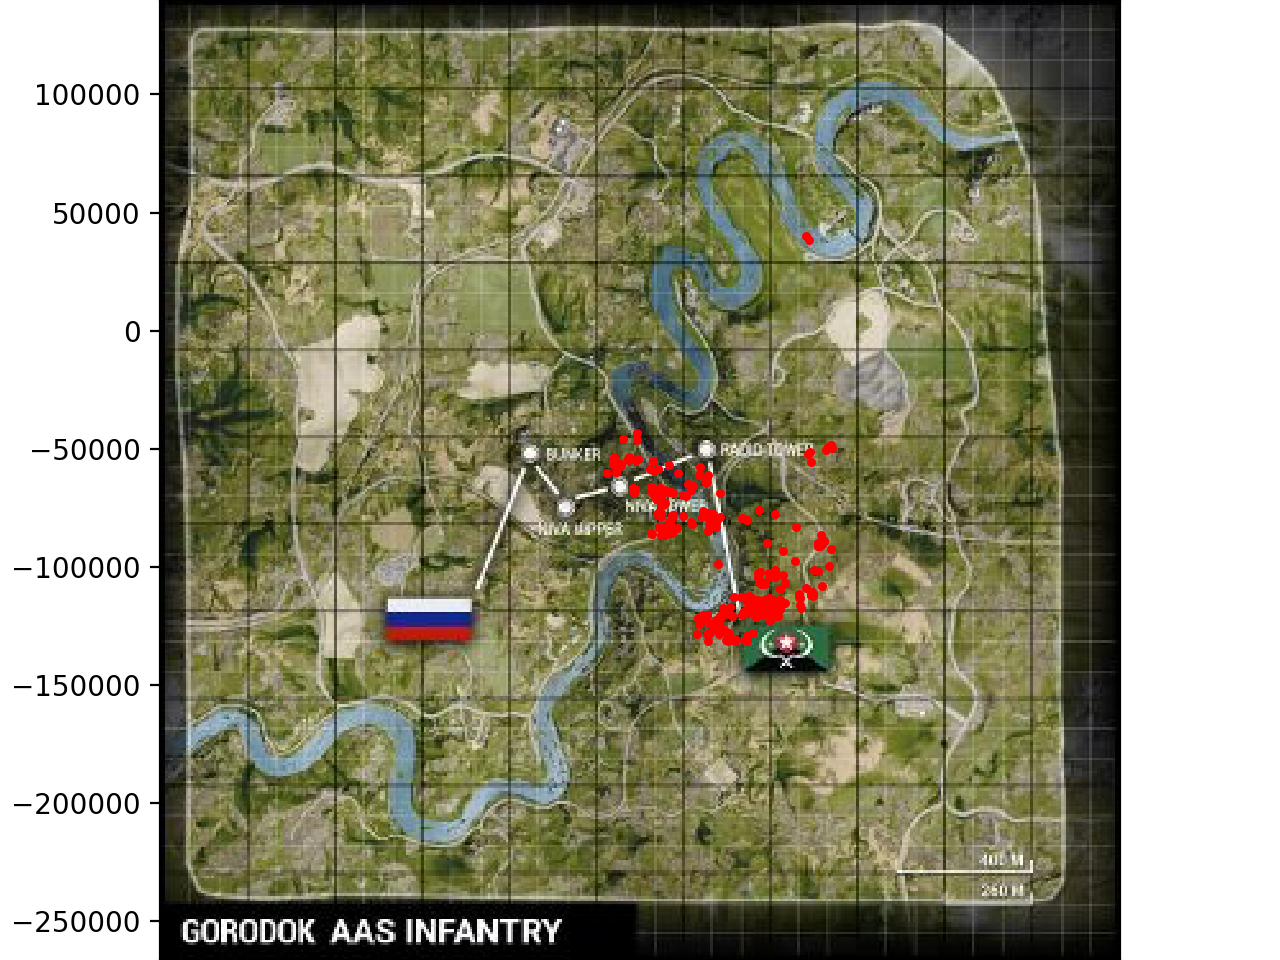

In [156]:
# plot kills

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# ([0, 0, 1, 1])
bg_figname = 'minimap_true.png'
img = plt.imread(bg_figname)
axis_extent = (-246400, 159990,
               -266400, 140000)
ax.imshow(img, extent=axis_extent)
for player_key in players:
    player = players[player_key]
    pos_x =  []
    pos_y =  []
    #player_kill_stamps = player['kill_stamps']
    player_kill_stamps = player.kill_stamps
    if player_kill_stamps:
        indices = []
        for stamp in player_kill_stamps:
            x,y = player_kill_pos(player_key, stamp)
            pos_x.append(x)
            pos_y.append(y)

        ax.scatter(pos_x, pos_y, c='r', s=5)

<IPython.core.display.Javascript object>


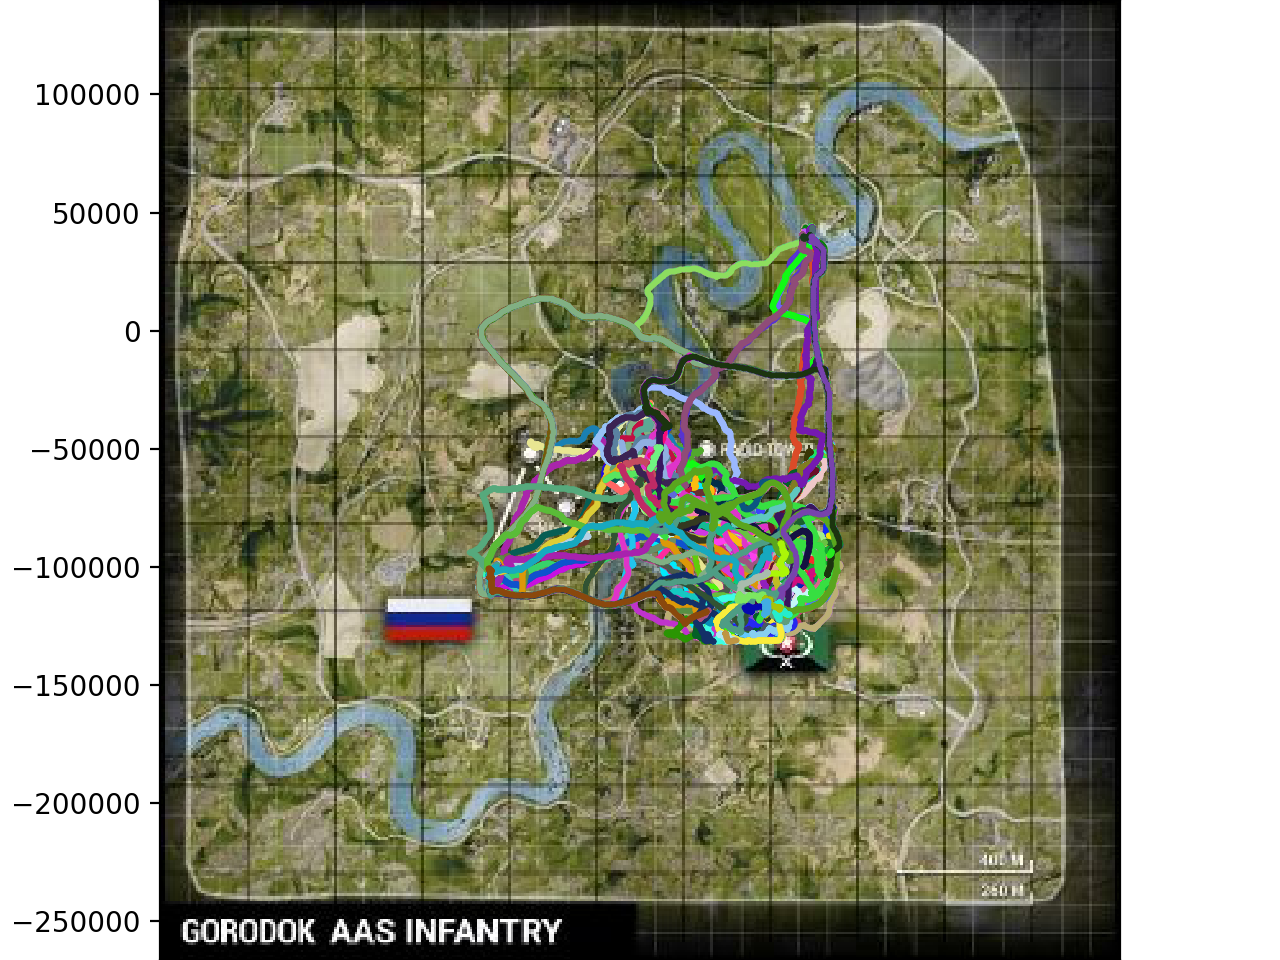

In [157]:
# plot movement
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# ([0, 0, 1, 1])
bg_figname = 'minimap_true.png'
img = plt.imread(bg_figname)
axis_extent = (-246400, 159990,
               -266400, 140000)
ax.imshow(img, extent=axis_extent)

for player_key in players:
    player = players[player_key]
    player_indices = player.tick_indices
    pos_x = id_data['pos_x'][player_indices]
    pos_y = id_data['pos_y'][player_indices]
    ax.scatter(pos_x, pos_y, c=np.random.rand(3,), s=1)

In [ ]:
# Combined plot


In [ ]:
np.max(id_data['pos_y'])

pos_x = id_data['pos_x']
pos_y = id_data['pos_y']

# player ids

players = {}
for player in players:
    print(player)
    player_dict = {}
    tick_indices = id_data['recording_id'] == player
    player_ticks = id_data[tick_indices]
    
    try:
        player_kills = killers[player]
    except:
        # No kills
        continue
    player_tick_stamps = np.array(player_ticks['timestamp'].values.tolist())
    kill_indices = []
    kill_stamps = player_kills['timestamp']
    for kill_stamp in kill_stamps.values():
        # kill_tick_idx = find_nearest_idx(player_tick_stamps, kill_stamp)
        # corresponding_player_tick = player_ticks.iloc[kill_tick_idx]
        kill_tick_idx = id_data['timestamp'] == kill_stamp
        kill_indices.append(kill_tick_idx)
    
    player_dict['tick_indices'] = tick_indices
    player_dict['kill_indices'] = kill_indices
    
    
    players[player] = player_dict

<IPython.core.display.Javascript object>


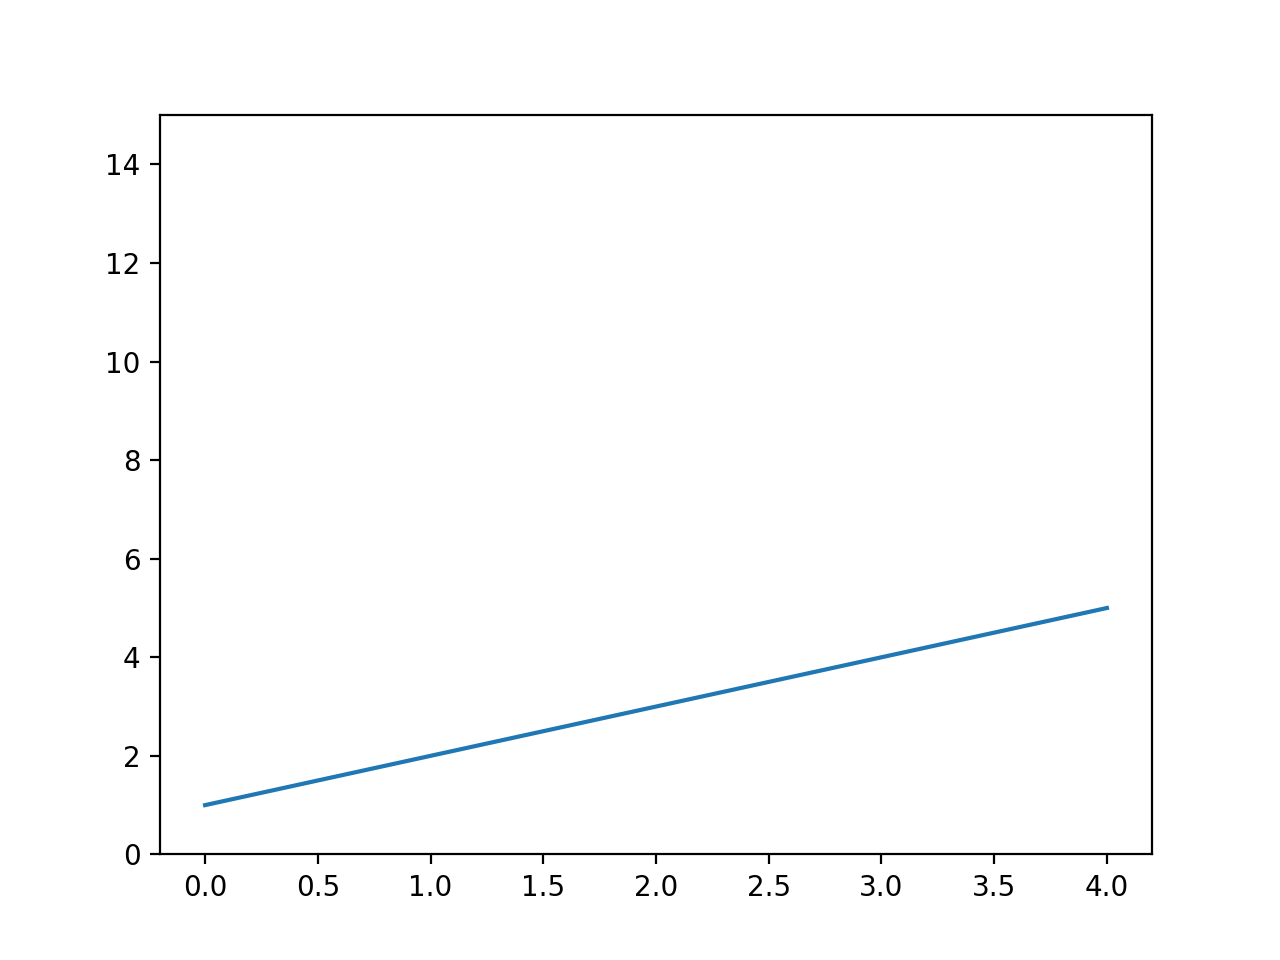

TypeError: pause() takes exactly 1 argument (0 given)